### I would think, the answer is no! The CNN would only be trying to minimize the loss function - it doesn't necessarily have to learn the function we might be looking for OR it might not be able to reach till that optimal solution...at the end, CNN's goal is to minimize the loss, however possible.

#### How do I plan to test it ? Train CNN on the data only for three quadrants of the clock ( 0 - 9 hour hand ) and test on the remaining quadrant - doing this for both feature engineering and the image data. Hopefully feature engineered data would work perfectly and should be able to predict stuff for test data. Let's checkout! 

In [1]:
import numpy as np
import os
from PIL import Image
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras.applications import VGG16
import keras.preprocessing.image as image_processor
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
BASE_PATH = '/Users/gursharan/Desktop/clocks/'

In [3]:
input_size = 100
def get_model():
    base_model = VGG16(input_tensor=keras.Input(shape=(input_size, input_size, 3)),
                         weights='imagenet',include_top=False)
    base_model.trainable = False
    
    for base_layer in base_model.layers:
        base_layer.trainable = False
    layer_1 = Flatten()
    dense_1 = Dense(256, activation='relu')
    dropout_1 = Dropout(0.5)
    dense_2 = Dense(32, activation='relu')
    dense_3 = Dense(3, activation='relu')
    model = Sequential(
            [base_model, layer_1,
            dense_1, dropout_1, dense_2, dense_3]) 
    model.compile(loss='mse',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mae'])
    return model

In [23]:
def get_output_from_name( name ):
    time = name[len('clock_'):-4]
    time = [ int(x) for x in time.split('_') ]
    angles = get_angle_from_time(time[0], time[1], time[2])
    return time, angles

def get_angle_from_time( hour, minute, second ):
    second_angle = 6*second
    hour_angle = 30*( hour + minute/60 + second/3600) 
    minute_angle = 6*( minute + second/60)
    return [hour_angle, minute_angle, second_angle]
    
def get_all_data():
    all_files = os.listdir(BASE_PATH)
    total_files = len(all_files)
    total_test_files = total_files//4
    total_train_files = (3*total_files)//4
    
    train_X = np.ones(((total_train_files),input_size,input_size,3))
    train_Y = np.ones(((total_train_files),3))
    
    test_X = np.ones(((total_test_files),input_size,input_size,3))
    test_Y = np.ones(((total_test_files),3))
    
    index_test = 0
    index_train = 0
    for file in all_files:
        file_name = os.path.join( BASE_PATH, file )
        time, angles = get_output_from_name( file )
        
        img = image_processor.load_img( file_name, target_size=(input_size, input_size))
        img = image_processor.img_to_array(img)
        
        if( time[0] >= 9 ): #test file
            test_X[index_test,:,:,:] = img
            test_Y[index_test,:] = angles
            index_test = index_test + 1
        else:
            train_X[index_train,:,:,:] = img
            train_Y[index_train,:] = angles
            index_train = index_train + 1
    return( train_X, train_Y, test_X, test_Y )

In [7]:
(X_train_and_val, Y_train_and_val, test_X, test_Y) = get_all_data()

In [9]:
total_train_val_examples = Y_train_and_val.shape[0]
data_indices = np.random.permutation(total_train_val_examples)
training_data_indices = data_indices[:int(0.8*total_train_val_examples)]
validation_data_indices = data_indices[int(0.8*total_train_val_examples):]
train_X,train_Y = X_train_and_val[training_data_indices,:,:,:], Y_train_and_val[training_data_indices,:]
val_X,val_Y = X_train_and_val[validation_data_indices,:,:,:], Y_train_and_val[validation_data_indices,:]

In [10]:
print('Total training examples:', train_X.shape[0])
print('Total validation examples:', val_X.shape[0])
print('Total testing examples:', test_X.shape[0]) 

Total training examples: 25920
Total validation examples: 6480
Total testing examples: 10800


In [12]:
model_1 = get_model()
history = model_1.fit(train_X, train_Y, epochs=5, validation_data=(val_X, val_Y))

Train on 25920 samples, validate on 6480 samples
Epoch 1/5
25920/25920 [==============================] - 26507s 1s/step - loss: 3574.2766 - mae: 43.8286 - val_loss: 1323.3756 - val_mae: 24.4154
Epoch 2/5
25920/25920 [==============================] - 604s 23ms/step - loss: 2065.7887 - mae: 33.4784 - val_loss: 1174.8887 - val_mae: 25.4864
Epoch 3/5
25920/25920 [==============================] - 681s 26ms/step - loss: 1698.4631 - mae: 30.4132 - val_loss: 962.9040 - val_mae: 23.6004
Epoch 4/5
25920/25920 [==============================] - 687s 27ms/step - loss: 1480.1043 - mae: 28.3573 - val_loss: 557.7070 - val_mae: 15.9288
Epoch 5/5
25920/25920 [==============================] - 632s 24ms/step - loss: 1342.3565 - mae: 27.1358 - val_loss: 913.3405 - val_mae: 23.8739


In [16]:
print(model_1.evaluate(test_X, test_Y))

10800/10800 [==============================] - 233s 22ms/step
[20240.25960358796, 105.01074981689453]


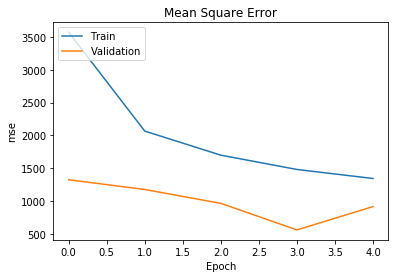

In [15]:
plt.plot(history.history['loss'][0:5])
plt.plot(history.history['val_loss'][0:5])
plt.title('Mean Square Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

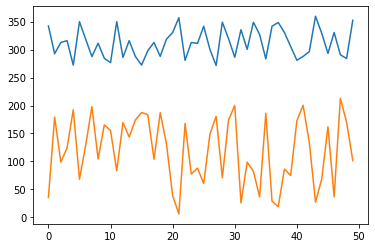

In [17]:
output = model_1.predict( test_X )
plt.plot(range(50), test_Y[0:50,0], label='actual'    )
plt.plot(range(50), output[0:50,0], label='predicted' )
plt.show()

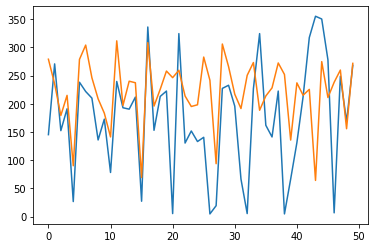

In [19]:
plt.plot(range(50), test_Y[0:50,1], label='actual'    )
plt.plot(range(50), output[0:50,1], label='predicted' )
plt.show()

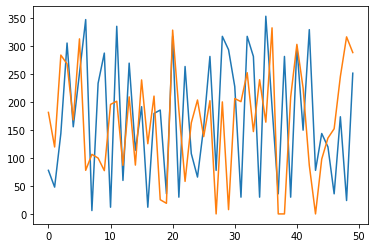

In [32]:
plt.plot(range(50), test_Y[0:50,2], label='actual'    )
plt.plot(range(50), output[0:50,2], label='predicted' )
plt.show()

#### There is a big difference here for hour hand!! Ideally because neural network learn the output values for hour between 0 and 9 ( i.e. angle between 0 and 270 ). This does show importance of output space that neural networks need to learn upon

#### Let's train it on data with hour hand between 0 to 4 and 7 to 12. This way we hope to include all input range. Also the missing data is almost in the centre of output space for hour hand, so we ideally we should get better results!

In [24]:
def get_all_data_2():
    all_files = os.listdir(BASE_PATH)
    total_files = len(all_files)
    total_test_files = total_files//4
    total_train_files = (3*total_files)//4
    
    train_X = np.ones(((total_train_files),input_size,input_size,3))
    train_Y = np.ones(((total_train_files),3))
    
    test_X = np.ones(((total_test_files),input_size,input_size,3))
    test_Y = np.ones(((total_test_files),3))
    
    index_test = 0
    index_train = 0
    for file in all_files:
        file_name = os.path.join( BASE_PATH, file )
        time, angles = get_output_from_name( file )
        
        img = image_processor.load_img( file_name, target_size=(input_size, input_size))
        img = image_processor.img_to_array(img)
        
        if( time[0] >= 4 and time[0] < 7): #test file
            test_X[index_test,:,:,:] = img
            test_Y[index_test,:] = angles
            index_test = index_test + 1
        else:
            train_X[index_train,:,:,:] = img
            train_Y[index_train,:] = angles
            index_train = index_train + 1
    return( train_X, train_Y, test_X, test_Y )

In [25]:
(X_train_and_val_2, Y_train_and_val_2, test_X_2, test_Y_2) = get_all_data_2()

In [26]:
train_X_2,train_Y_2 = X_train_and_val_2[training_data_indices,:,:,:], Y_train_and_val_2[training_data_indices,:]
val_X_2,val_Y_2 = X_train_and_val_2[validation_data_indices,:,:,:], Y_train_and_val_2[validation_data_indices,:]

In [27]:
print('Total training examples:', train_X_2.shape[0])
print('Total validation examples:', val_X_2.shape[0])
print('Total testing examples:', test_X_2.shape[0]) 

Total training examples: 25920
Total validation examples: 6480
Total testing examples: 10800


In [28]:
model_2 = get_model()
history_2 = model_2.fit(train_X_2, train_Y_2, epochs=5, validation_data=(val_X_2, val_Y_2))

Train on 25920 samples, validate on 6480 samples
Epoch 1/5
25920/25920 [==============================] - 667s 26ms/step - loss: 19238.8279 - mae: 96.1036 - val_loss: 17798.9106 - val_mae: 83.9497
Epoch 2/5
25920/25920 [==============================] - 754s 29ms/step - loss: 9476.4184 - mae: 62.5903 - val_loss: 1612.8685 - val_mae: 28.4170
Epoch 3/5
25920/25920 [==============================] - 744s 29ms/step - loss: 2539.0852 - mae: 37.3502 - val_loss: 977.8044 - val_mae: 21.8277
Epoch 4/5
25920/25920 [==============================] - 775s 30ms/step - loss: 2079.8646 - mae: 33.5749 - val_loss: 3034.4960 - val_mae: 47.6287
Epoch 5/5
25920/25920 [==============================] - 778s 30ms/step - loss: 1787.3569 - mae: 30.9727 - val_loss: 2015.2767 - val_mae: 38.6407


In [29]:
print(model_2.evaluate(test_X_2, test_Y_2))

10800/10800 [==============================] - 254s 23ms/step
[2611.9543395543983, 39.23916244506836]


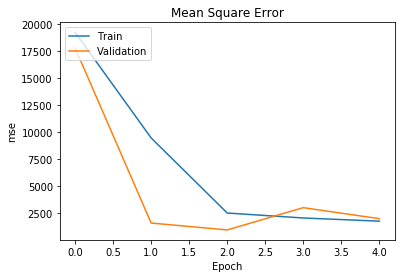

In [30]:
plt.plot(history_2.history['loss'][0:5])
plt.plot(history_2.history['val_loss'][0:5])
plt.title('Mean Square Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
output = model_2.predict( test_X_2 )

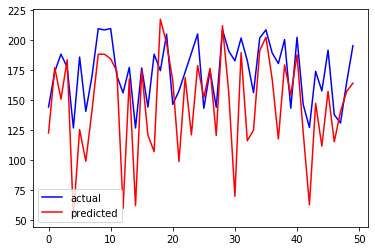

In [38]:
plt.plot(range(50), test_Y_2[0:50,0], label='actual', color='b')
plt.plot(range(50), output[0:50,0], label='predicted',color='r' )
plt.legend()
plt.show()

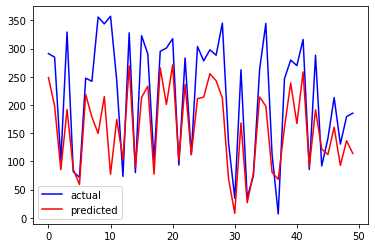

In [37]:
plt.plot(range(50), test_Y_2[0:50,1], label='actual', color='b'   )
plt.plot(range(50), output[0:50,1], label='predicted',color='r' )
plt.legend()
plt.show()

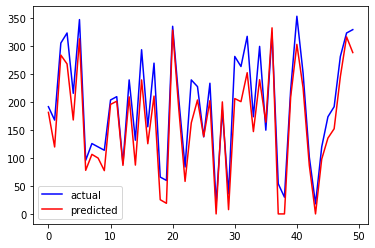

In [39]:
plt.plot(range(50), test_Y_2[0:50,2], label='actual', color='b')
plt.plot(range(50), output[0:50,2], label='predicted', color='r')
plt.legend()
plt.show()

#### It looks better than before. However note that neural networks do not necessarily learn the right mapping! They just attempt to learn right mapping for given input and output. The networks are as good as what you feed them

#### Let's try this on network with engineered features!

In [73]:
def get_model_features():
    model = Sequential()
    model.add( Dense(64, activation='relu', input_shape=(3,)) )
    model.add( Dense(64, activation='relu') )
    model.add( Dense(3, activation='relu') )
    model.compile(loss='mse',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mae'])
    return model

model_features = get_model_features()
model_features.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                256       
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 195       
Total params: 4,611
Trainable params: 4,611
Non-trainable params: 0
_________________________________________________________________


In [74]:
def get_all_data_features():
    all_files = os.listdir(BASE_PATH)
    total_files = len(all_files)
    total_test_files = total_files//4
    total_train_files = (3*total_files)//4
    
    X = np.ones(((total_train_files),3))
    Y = np.ones(((total_train_files),3))
    
    test_X = np.ones(((total_test_files),3))
    test_Y = np.ones(((total_test_files),3))
    
    index_test = 0
    index_train = 0
    
    for file in all_files:
        time, angles = get_output_from_name( file )
        if( time[0] >= 4 and time[0] < 7): #test file
            test_X[index_test,:] = time
            test_Y[index_test,:] = angles
            index_test = index_test + 1
        else:
            X[index_train,:] = time
            Y[index_train,:] = angles
            index_train = index_train + 1
    return( X, Y, test_X, test_Y )

X_features,Y_features,test_X_f,test_Y_f = get_all_data_features()

In [75]:
train_X_f,train_Y_f = X_features[training_data_indices,:], Y_features[training_data_indices,:]
val_X_f,val_Y_f = X_features[validation_data_indices,:], Y_features[validation_data_indices,:]

In [76]:
print('Training examples:', train_X_f.shape)
print('Validation examples:', val_X_f.shape)
print('Testing examples:', test_X_f.shape) 

Training examples: (25920, 3)
Validation examples: (6480, 3)
Testing examples: (10800, 3)


In [72]:
train_Y_f[0:10]

array([[ 85.53333333, 306.4       ,  24.        ],
       [321.35833333, 256.3       , 258.        ],
       [ 55.01666667, 300.2       ,  12.        ],
       [ 52.28333333, 267.4       , 204.        ],
       [323.275     , 279.3       , 198.        ],
       [ 54.55      , 294.6       ,  36.        ],
       [100.29166667, 123.5       , 210.        ],
       [ 90.325     ,   3.9       , 234.        ],
       [ 50.28333333, 243.4       , 204.        ],
       [ 36.43333333,  77.2       , 312.        ]])

In [77]:
history_f = model_features.fit(train_X_f, train_Y_f, 
                    epochs=10, validation_data=(val_X_f, val_Y_f))

Train on 25920 samples, validate on 6480 samples
Epoch 1/10
25920/25920 [==============================] - 1s 34us/step - loss: 1189.8635 - mae: 12.6071 - val_loss: 39.6016 - val_mae: 5.6994
Epoch 2/10
25920/25920 [==============================] - 1s 28us/step - loss: 24.0018 - mae: 3.8035 - val_loss: 40.3578 - val_mae: 5.5796
Epoch 3/10
25920/25920 [==============================] - 1s 27us/step - loss: 21.2293 - mae: 3.4676 - val_loss: 8.8375 - val_mae: 2.5277
Epoch 4/10
25920/25920 [==============================] - 1s 27us/step - loss: 20.1069 - mae: 3.4618 - val_loss: 17.1562 - val_mae: 3.2625
Epoch 5/10
25920/25920 [==============================] - 1s 28us/step - loss: 20.1996 - mae: 3.5082 - val_loss: 10.1937 - val_mae: 2.9007
Epoch 6/10
25920/25920 [==============================] - 1s 31us/step - loss: 19.8261 - mae: 3.5633 - val_loss: 34.5129 - val_mae: 5.3821
Epoch 7/10
25920/25920 [==============================] - 1s 31us/step - loss: 16.8823 - mae: 3.1811 - val_loss: 14

In [78]:
output_f = model_features.predict(test_X_f)

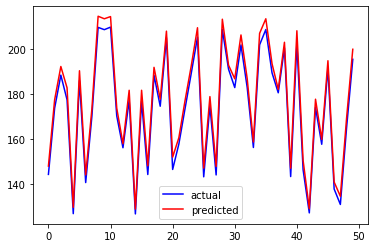

In [79]:
plt.plot(range(50), test_Y_f[0:50,0], label='actual', color='b')
plt.plot(range(50), output_f[0:50,0], label='predicted', color='r')
plt.legend()
plt.show()

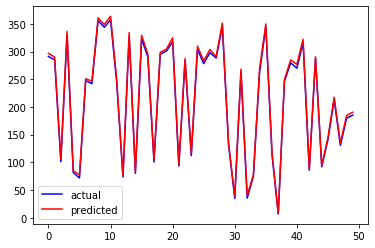

In [80]:
plt.plot(range(50), test_Y_f[0:50,1], label='actual', color='b')
plt.plot(range(50), output_f[0:50,1], label='predicted', color='r')
plt.legend()
plt.show()

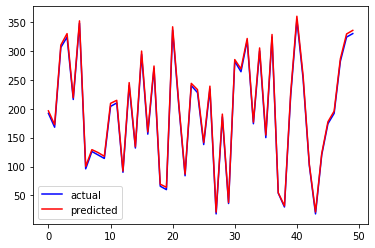

In [81]:
plt.plot(range(50), test_Y_f[0:50,2], label='actual', color='b')
plt.plot(range(50), output_f[0:50,2], label='predicted', color='r')
plt.legend()
plt.show()

#### ON FIRST LOOK : Feature engineering can point the network to look for the optimal mapping in the right direction! We see feature engineered network did learn way better mapping than the network running on images!
#### Let's look if mse for hour, minute and second hand angles are in the same range or not

In [86]:
output_1 = model_1.predict( test_X )
mse_hour_hand = np.sqrt(np.sum((test_Y[:,0] - output_1[:,0])**2))
mse_min_hand = np.sqrt(np.sum((test_Y[:,1] - output_1[:,1])**2))
mse_sec_hand = np.sqrt(np.sum((test_Y[:,2] - output_1[:,2])**2))
print('Learning on space where hour hand is between 0 and 9 and testing on rest...')
print('rmse for hour hand predictions :', mse_hour_hand)
print('rmse for minute hand predictions :', mse_min_hand)
print('rmse for second hand predictions :', mse_sec_hand)

Learning on space where hour hand is between 0 and 9 and testing on rest...
rmse for hour hand predictions : 23096.023983956424
rmse for minute hand predictions : 9200.178371845443
rmse for second hand predictions : 6141.238260481865


In [87]:
mse_hour_hand = np.sqrt(np.sum((test_Y_2[:,0] - output[:,0])**2))
mse_min_hand = np.sqrt(np.sum((test_Y_2[:,1] - output[:,1])**2))
mse_sec_hand = np.sqrt(np.sum((test_Y_2[:,2] - output[:,2])**2))
print('Learning on space where hour hand is between (0-4 and 7-12) and testing on rest...')
print('rmse for hour hand predictions :', mse_hour_hand)
print('rmse for minute hand predictions :', mse_min_hand)
print('rmse for second hand predictions :', mse_sec_hand)

Learning on space where hour hand is between (0-4 and 7-12) and testing on rest...
rmse for hour hand predictions : 4889.6616178591585
rmse for minute hand predictions : 6594.059127855107
rmse for second hand predictions : 4151.736295715562


#### It seems now, networks, in general, do learn good enough mapping even with the missing chunk of data in it's data space, given it is taught the output range for values. So if we get the data with missing range on the edges, do we lose hope? NO. If we know beforehand the value limits of different features of data, we can play with the feature space to help NN understand it. As an example, here, if we are given only the data with clock hour hand between 0 and 9, and want to test on one with 9-12, all we need to do is rotate this mapping by say 180 degrees, now in our new space, missing data is between 3 to 6, and our training data ensures that it better understands the limits of output values! Let's test it out? We already have, with missing data being for hour hand between 4 to 7 though!


### So what's the conclusion? CNNs always learn the generic mapping? NO.
### Okay, what if the data we provide span the input/output space with just some chunk of data missing in between, as per our experiment here, it does learn good enough mapping ? Umm...NO.
### Why? For example, say you learn about different animal classification using two features ear and feet. And you exclude all cat ears from training. In testing, we test on the cat ears but do not include the feet of cat, neural network would not really understand how to map that, especially if we confuse it with other similar looking ears ( tiger's ? ) in the training data. This is why it is good to have as much generic data as possible to train the network, so that we do not miss any key features entirely.
### Is that because neural networks do not have the capability to learn general mapping? NO, if we can provide the network with a nudge in right direction, it does learn the correct mapping.